# Relationships between SAT scores and demographic factors in New York City public schools

The SAT, or Scholastic Aptitude Test, is a test that high school seniors in the U.S. take every year. The SAT has three sections, each of which is worth a maximum of 800 points. Colleges use the SAT to determine which students to admit. High average SAT scores are usually indicative of a good school.

New York City has published data on student SAT scores by high school (reference: https://data.cityofnewyork.us/Education/SAT-Results/f9bf-2cp4), along with additional demographic data sets. The following data sets are used in this project:

1. SAT scores by school - SAT scores for each high school in New York City
2. School attendance - Attendance information for each school in New York City
3. Class size - Information on class size for each school
4. AP test results - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
5. Graduation outcomes - The percentage of students who graduated, and other outcome information
6. Demographics - Demographic information for each school
7. School survey - Surveys of parents, teachers, and students at each school

The data sets are combined as follows for analysis:

## 1. Data Set Cleaning

#### 1.1 Read in the data

In [17]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

#### 1.2 Read in the surveys

In [3]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

#### 1.3 Add DBN columns

In [4]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

#### 1.4 Convert columns to numeric

In [5]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

#### 1.5 Condense datasets

In [6]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

#### 1.6 Convert AP scores to numeric

In [7]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

#### 1.7 Combine the datasets

In [8]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

#### 1.8 Add a school district column for mapping

In [9]:
def get_two_characters(string):
    return string[0:2]

combined["school_dist"] = combined["DBN"].apply(get_two_characters)

#### 1.9 Find correlations

In [10]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

## 2. Survey correlations

In [11]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

List of fields in combined that originally came from a survey of parents, teachers, and students:

In [12]:
survey_fields

['rr_s',
 'rr_t',
 'rr_p',
 'N_s',
 'N_t',
 'N_p',
 'saf_p_11',
 'com_p_11',
 'eng_p_11',
 'aca_p_11',
 'saf_t_11',
 'com_t_11',
 'eng_t_11',
 'aca_t_11',
 'saf_s_11',
 'com_s_11',
 'eng_s_11',
 'aca_s_11',
 'saf_tot_11',
 'com_tot_11',
 'eng_tot_11',
 'aca_tot_11']

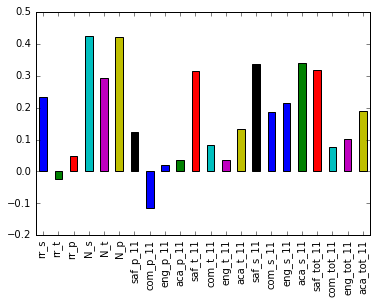

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

combined.corr()["sat_score"][survey_fields].plot.bar()

plt.show()

There are higher coorelations between N_s, N_t, N_p and sat_score. saf_t_11 and saf_s_11, which measure how teachers and students perceive safety at school, correlated highly with sat_score.

#### 2.1 Safety Scores differences in SAT scores

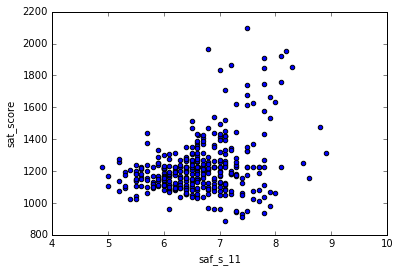

In [14]:
%matplotlib inline
combined.plot.scatter("saf_s_11", "sat_score")
plt.show()

There is a correlation between SAT scores and safety, there are a few schools with both high SAT scores and high safety scores, and vice versa. No school with a safety score lower than 6.5 has an average SAT score higher than 1600.

Average safety score for each district:

In [18]:
%matplotlib inline

# group safety scores by districts
districts = combined.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

districts.head

<bound method DataFrame.head of    school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0           01                       441.833333           473.333333   
1           02                       426.619092           444.186256   
2           03                       428.529851           437.997512   
3           04                       402.142857           416.285714   
4           05                       427.159915           438.236674   
5           06                       382.011940           400.565672   
6           07                       376.461538           380.461538   
7           08                       386.214383           395.542741   
8           09                       373.755970           383.582836   
9           10                       403.363636           418.000000   
10          11                       389.866667           394.533333   
11          12                       364.769900           379.109453   
12          13                  

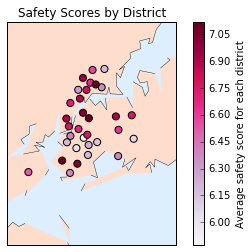

In [66]:
# scatter plot of the saf_s_11 column VS the sat_score in combined

%matplotlib inline

from mpl_toolkits.basemap import Basemap


# llcrnrlon: The lower left corner geographical longitude
# llcrnrlat: The lower left corner geographical latitude
# urcrnrlon: The upper right corner geographical longitude
# urcrnrlat: The upper right corner geographical latitude

m = Basemap(projection="gnom",
            lat_0=40.730610, lon_0=-73.935242,
            llcrnrlat=40.400000, 
            urcrnrlat=41.000000, 
            llcrnrlon=-74.200000, 
            urcrnrlon=-73.600000,
            resolution='i')

m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
m.drawmapboundary(fill_color="#DDEEFF")

# #000000 Color Hex Black
m.drawcoastlines(color='#000000', linewidth=0.4)
m.drawrivers(color='#000000', linewidth=0.4)
                  
longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

# If latlon keyword is set to True, x,y are intrepreted as longitude and latitude in degrees
# c=column: colour the points by another variable (colour the points by the average safety score)
# cmap: Colormap
# reference: http://chris35wills.github.io/courses/PythonPackages_matplotlib/matplotlib_scatter/

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts["saf_s_11"], cmap=plt.cm.PuRd)


# reference: https://jakevdp.github.io/PythonDataScienceHandbook/04.13-geographic-data-with-basemap.html

plt.colorbar(label="Average safety score for each district")
plt.title("Safety Scores by District")

plt.show()

#### 2.2 Racial differences in SAT scores

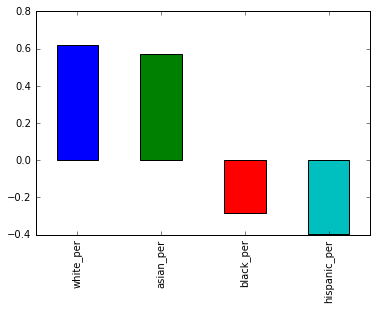

In [72]:
import matplotlib.pyplot as plt
from numpy import arange

race = ["white_per", "asian_per", "black_per", "hispanic_per"]

# bar plot of the correlations between the columns above and sat_score
correlations = combined.corr()["sat_score"][race].plot.bar()

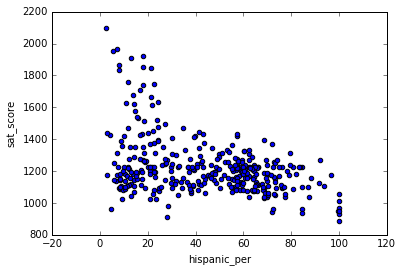

In [74]:
# scatter plot of hispanic_per vs. sat_score

combined.plot.scatter("hispanic_per", "sat_score")

In [79]:
# schools with a hispanic_per greater than 95%

schools_hispanic_95_above = combined[combined["hispanic_per"] > 95]["SCHOOL NAME"]

print("Schools with hispanic_per greater than 95%:")
print(schools_hispanic_95_above)

Schools with hispanic_per greater than 95%:
44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In [80]:
# schools with a hispanic_per less than 10% and an average SAT score greater than 1800

hispanic_10_below_SAT_1800_above = combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"]

print("Schools with a hispanic_per less than 10% and an average SAT score greater than 1800:")
print(hispanic_10_below_SAT_1800_above)

Schools with a hispanic_per less than 10% and an average SAT score greater than 1800:
37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


#### 2.3 Gender differences in SAT scores

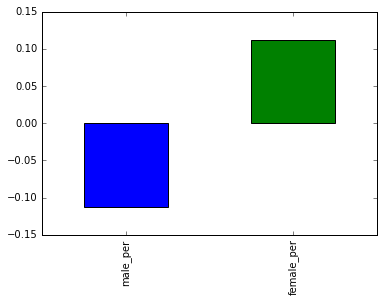

In [82]:
import matplotlib.pyplot as plt
from numpy import arange

gender = ["male_per", "female_per"]

# bar plot of the correlations between the columns above and sat_score
correlations = combined.corr()["sat_score"][gender].plot.bar()

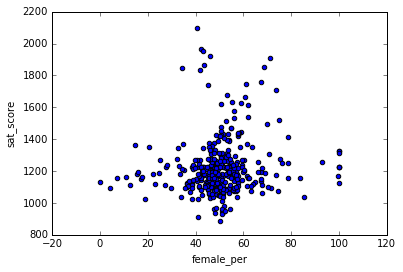

In [83]:
# scatter plot of female_per vs. sat_score

combined.plot.scatter("female_per", "sat_score")

In [85]:
# bar plot of the correlations between the columns above and sat_score

female_60_above_SAT_1700_above = combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]

print("Schools with a female_per greater than 60% and an average SAT score greater than 1700:")
print(female_60_above_SAT_1700_above)

Schools with a female_per greater than 60% and an average SAT score greater than 1700:
5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


## 3. AP Exam Scores vs SAT Scores

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects. We would like to explore the relationship between AP scores and SAT scores:

Percentage of students in each school that took an AP exam:

In [89]:
# divide AP Test Takers column by the total_enrollment column

combined["ap_per"] = combined["AP Test Takers "] / combined["total_enrollment"]

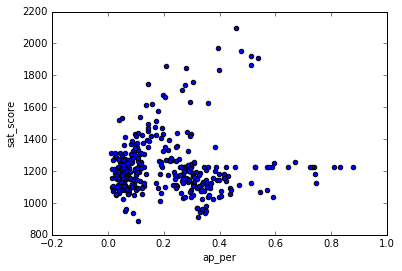

In [90]:
# scatter plot of ap_per vs. sat_score

combined.plot.scatter("ap_per", "sat_score")

plt.show()